<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка" data-toc-modified-id="Загрузка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка</a></span></li><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка текста</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Оценка-качества-и-выбор-лучшей-модели" data-toc-modified-id="Оценка-качества-и-выбор-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оценка качества и выбор лучшей модели</a></span></li><li><span><a href="#Формулирование-выводов" data-toc-modified-id="Формулирование-выводов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Формулирование выводов</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

**Введение:**

Интернет-магазин "Викишоп" внедряет инновационный сервис, предоставляющий пользователям возможность редактировать и дополнять описания товаров, аналогично вики-сообществам. Клиенты смогут предлагать свои правки и комментировать изменения, внесенные другими пользователями. Для обеспечения качества контента и поддержания дружелюбной атмосферы "Викишопу" необходим инструмент, способный автоматически распознавать токсичные комментарии и направлять их на модерацию.

**Цель проекта:**

Разработать и обучить модель машинного обучения, классифицирующую комментарии на позитивные и негативные (токсичные). Модель должна обеспечивать хорошее качество классификации, достигая значения метрики *F1* не менее 0.75.

**Задачи проекта:**

1. **Загрузка и предобработка данных**: Загрузить предоставленный набор данных, содержащий тексты комментариев и метки токсичности. Выполнить предобработку данных, включающую очистку текста, токенизацию, удаление стоп-слов, лемматизацию и векторизацию.
2. **Обучение моделей**: Обучить различные модели машинного обучения для решения задачи классификации.
3. **Оценка качества и выбор лучшей модели**: Оценить качество обученных моделей на тестовой выборке, используя метрику *F1*. Сравнить результаты и выбрать модель, демонстрирующую наилучшее качество.
4. **Формулирование выводов**: Подвести итоги проделанной работы, описать достигнутые результаты, а также потенциальные улучшения и направления для дальнейших исследований.

**Данные:**

Предоставленный набор данных toxic_comments.csv содержит два столбца:

*   text: Текст комментария на английском языке.
*   toxic: Целевой признак, бинарная метка, обозначающая токсичность комментария (1 - токсичный, 0 - нетоксичный).

**Библиотеки**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import time
import warnings

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import notebook 

warnings.filterwarnings("ignore")

**Константы**

In [2]:
RANDOM_STATE = 42

## Загрузка и предобработка данных

### Загрузка

In [3]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
df.head(3)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0


In [5]:
df.tail(3)

,Unnamed: 0,text,toxic
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


Загрузка данных прошла успешно. В датафрейме присутствуют три колонки. Колонка "Unnamed: 0", судя по названию, содержит неизвестные данные, и её, вероятно, следует удалить в будущем. Колонка "text", как и указано в описании, содержит текст. Целевой признак находится в колонке "toxic", что также соответствует описанию.

Важно учесть, что в комментариях встречаются символы переноса строки ("\\n"), текст написан в разных регистрах, а также присутствуют стоп-слова. Следовательно, потребуется предварительная обработка текста.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Датасет содержит 159 292 комментария. Пропущенные значения отсутствуют. Типы данных в каждой колонке соответствуют ожидаемым.

In [7]:
df.duplicated().sum()

0

В данных дубликаты отсутствуют.

Посмотрим соотношение классов в целевой переменной. Для этого создадим функцию get_grafic(df, target), которая будет визуализировать соотношение меток классов.

Функция get_grafic(df, target) принимает два аргумента:

*   df:  Датафрейм, в котором содержится целевая переменная.
*   target: Название столбца (признака) в датафрейме df, который содержит метки классов. 

In [8]:
def get_grafic(df, target):    
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))

    ax = sns.countplot(x=target, data=df, palette="pastel")

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

    plt.title('Распределение токсичности комментариев', fontsize=16, fontweight='bold')
    plt.xlabel('', fontsize=14)
    plt.ylabel('Количество комментариев', fontsize=14)
    plt.xticks([0, 1], ['Нетоксичные', 'Токсичные'], fontsize=12)

    # Вычисление отношения классов 0 к 1
    counts = df[target].value_counts()
    count0 = counts.get(0, 0)
    count1 = counts.get(1, 0)
    
    if count1 != 0:
        ratio = count0 / count1
        ratio_text = f'Отношение классов 0 к 1: {ratio:.1f} - 1'
    else:
        ratio_text = 'Отношение классов 0 к 1: Не определено'

    # Добавление текста с отношением на график
    plt.text(0.5, max(count0, count1)*0.9, ratio_text, 
             horizontalalignment='left', 
             fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.5))
    
    sns.despine(left=True)
    plt.tight_layout()

    plt.show()

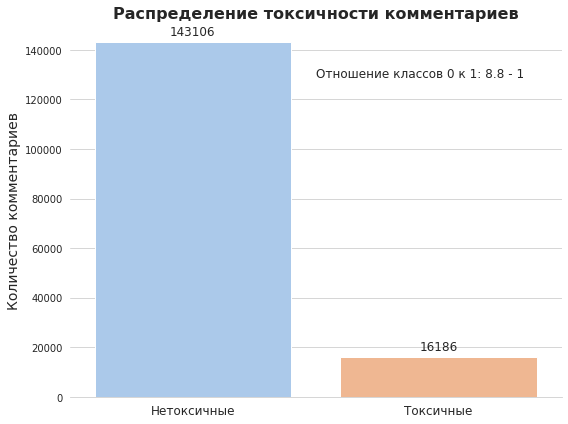

In [9]:
get_grafic(df, 'toxic')

В данных наблюдается существенный дисбаланс классов: соотношение количества нетоксичных комментариев (класс 0) к токсичным (класс 1) составляет приблизительно 8,8 к 1. Такой дисбаланс может привести к тому, что модель будет плохо предсказывать минорный класс (токсичные комментарии), что негативно скажется на итоговой метрике. Поэтому при разделении данных на обучающую и тестовую выборки необходимо использовать стратификацию. Для дополнительного выравнивания баланса классов и улучшения качества обучения рекомендуется применять методы сэмплирования.

### Предобработка текста

Переходим к предобработке текста, необходимой для обучения модели. Начнем с удаления признака, который не несет полезной информации для обучения.

In [10]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Далее подготовим тексты комментариев к обработке. Для этого с помощью регулярных выражений оставим в тексте только буквы английского алфавита и приведём все символы к нижнему регистру. Затем разделим текст на токены и одновременно удалим стоп-слова. Оставшиеся слова преобразуем в их начальную форму (лемму). Все эти операции будут выполняться функцией pre_processing(text).

In [13]:
def get_wordnet_pos(treebank_tag):
       if treebank_tag.startswith('J'):
           return wordnet.ADJ
       elif treebank_tag.startswith('V'):
           return wordnet.VERB
       elif treebank_tag.startswith('N'):
           return wordnet.NOUN
       elif treebank_tag.startswith('R'):
           return wordnet.ADV
       else:
           return wordnet.NOUN

In [14]:
def pre_processing(text):
    text = re.sub(r'[^a-z ]', ' ', text.lower()).strip()
    tokens = word_tokenize(text)
    
    tokens_with_pos = pos_tag(tokens)
    tokens_filtered = [(word, pos) for word, pos in tokens_with_pos if word not in stop_words]
    
    text = ' '.join([
        lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tokens_filtered
    ])
    return text

In [15]:
%%time
#pandarallel.initialize(progress_bar=True)
df['pre_text'] = df['text'].apply(pre_processing)

CPU times: user 8min 47s, sys: 4.46 s, total: 8min 52s
Wall time: 8min 55s


In [16]:
df.head(3)

,text,toxic,pre_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stick th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...


Функция успешно преобразовала комментарии. Признак text нам больше не нужен.

In [17]:
df.drop('text', axis=1, inplace=True)

Предлагаю проанализировать количество символов в комментариях.

In [18]:
df['len'] = df['pre_text'].str.len()

In [19]:
df['len'].describe()

count    159292.000000
mean        235.920040
std         370.557515
min           0.000000
25%          55.000000
50%         120.000000
75%         257.000000
max        5000.000000
Name: len, dtype: float64

Встречаются комментарии, состоящие из 0 символов. Вероятно, изначально они содержали только стоп-слова, которые были удалены в процессе предобработки. Средняя длина текста составляет 124 символа, при этом максимальная достигает 5000. Предлагаю исключить тексты с нулевой длиной, а все остальные оставить без изменений.

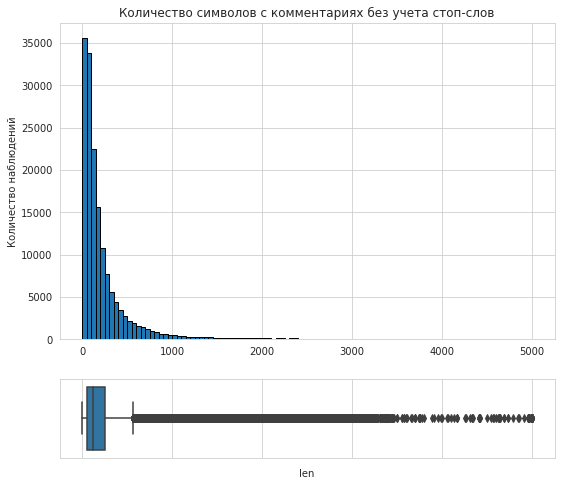

In [20]:
fig = plt.figure(figsize=(12, 8))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])
        
ax_main.hist(df['len'], bins=100, edgecolor='black')
sns.boxplot(x=df['len'], ax=ax_bottom)
ax_main.set(title='Количество символов с комментариях без учета стоп-слов', ylabel='Количество наблюдений')
plt.show()

In [21]:
df.shape

(159292, 3)

In [22]:
df = df.loc[df['len'] > 0]

In [23]:
df.shape

(159230, 3)

Удалили 62 наблюдения. Столбец len нам больше не нужен.

In [24]:
df.drop('len', axis=1, inplace=True)

Учитывая, что у нас достаточно данных, предлагаю разделить их следующим образом: 80% на обучающую выборку, 10% на валидационную и 10% на тестовую. На валидационной выборке будем настраивать гиперпараметры моделей. Когда целевая метрика F1 на валидационной выборке достигнет 0.75, мы применим лучшую модель к тестовой выборке и измерим F1.

In [25]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(df.drop('toxic', axis = 1),
                                                                df['toxic'],
                                                                test_size=0.2,
                                                                stratify = df['toxic'],
                                                                random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, 
                                                    y_test_valid,
                                                    test_size=0.5,
                                                    stratify = y_test_valid,
                                                    random_state=42) 

Так как целевая метрика F1 — это среднее гармоническое между precision и recall, обе метрики должны иметь хорошие значения. Из-за сильного дисбаланса классов модель может плохо обучаться на минорном классе, в нашем случае 1. Поэтому я разработаю функцию undersampling(X_train, y_train, features, target, alpha=1), которая выполняет undersampling. Цель функции — уравнять классы, уменьшая размер мажорного класса. 

Функция принимает четыре аргумента: X_train и y_train для объединения в один датафрейм (чтобы сохранить разметку), target — целевая переменная, и alpha=1 — параметр, определяющий разницу между мажорным и минорным классом. Таким образом, мы будем обрезать тренировочную выборку для достижения баланса классов. Если качество будет недостаточным, будем увеличивать параметр alpha, чтобы увеличить объём обучающей выборки, пока F1 не станет приемлемым.

In [26]:
def undersampling(X_train, y_train, target, alpha=2):
    df = X_train.join(y_train)
    
    minor, major = df[target].unique()
    if df[df[target] == minor][target].count() > df[df[target] == major][target].count():
        minor, major = major, minor
    
    minor_df = df[df[target] == minor]
    minor_count = minor_df[target].count()
    major_df = df[df[target] == major].sample(int(minor_count * alpha), random_state=RANDOM_STATE)
    
    under_df = pd.concat([minor_df, major_df])
    under_df = shuffle(under_df, random_state=RANDOM_STATE)
    
    return under_df, under_df.drop(target, axis = 1), under_df[target]

Возвращаем сокращённый датафрейм и обновлённые X_train_under и y_train_under.

In [27]:
under_df, X_train_under, y_train_under = undersampling(X_train, y_train, 'toxic')

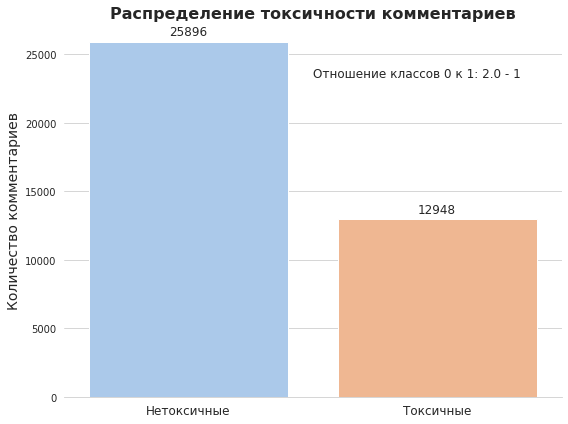

In [28]:
get_grafic(under_df, 'toxic')

In [29]:
pd.DataFrame({
    'Выборка':['X_train_under', 'y_train_under',
               'X_valid', 'y_valid',
               'X_test', 'y_test'],
    
    'Размер выборки':[X_train_under.shape, y_train_under.shape,
                      X_valid.shape, y_valid.shape,
                      X_test.shape, y_test.shape]
})

,Выборка,Размер выборки
0,X_train_under,"(38844, 1)"
1,y_train_under,"(38844,)"
2,X_valid,"(15923, 1)"
3,y_valid,"(15923,)"
4,X_test,"(15923, 1)"
5,y_test,"(15923,)"


## Обучение моделей

TF-IDF обучаем только на необрезанных тренировочных данных, чтобы максимально увеличить словарь слов. Затем трансформируем сокращённую тренировочную выборку, валидационную и тестовую выборки.

Мы обучаемся только на тестовой выборке, поскольку существует риск утечки данных.

In [30]:
count_tf_idf = TfidfVectorizer()
tfidf = count_tf_idf.fit(X_train['pre_text'])

tfidf_train = count_tf_idf.transform(X_train_under['pre_text'])
tfidf_valid = count_tf_idf.transform(X_valid['pre_text'])
tfidf_test = count_tf_idf.transform(X_test['pre_text'])

Для обучения я выбрал три модели: LogisticRegression, DecisionTreeClassifier и KNeighborsClassifier. Я остановился на них, потому что, на мой взгляд, они будут обучаться быстрее, чем ансамблевые алгоритмы и, тем более, нейросети.

In [31]:
models = [
    LogisticRegression(random_state=RANDOM_STATE),
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    KNeighborsClassifier()
]

models_parameters = [
    [
        'LogisticRegression', 
        {'C': range(1, 16, 3),
        'penalty': ['l1', 'l2']} 
    ],
    [
        'DecisionTreeClassifier',
        {'max_depth': range(5, 20)} 
    ],
    [
        'KNeighborsClassifier', 
        {'n_neighbors': range(1, 20)} 
    ]
]

Перейдём к обучению моделей. Я буду использовать RandomizedSearchCV для подбора лучших гиперпараметров. На каждой итерации цикла будем обучать одну модель, сохраняя её лучшие гиперпараметры, время обучения, время предсказания, а также значение метрики F1 на обучающей и валидационной выборках в словаре models_df. Также отмечу, что я планирую провести несколько циклов с различными размерами обучающей выборки, изменяя параметр alpha в функции undersampling. Результаты обучения и валидационных тестов будут представлены ниже.

In [32]:
%%time

models_df = {}

for i in notebook.tqdm(range(len(models))):
    rs = RandomizedSearchCV(
        models[i],
        models_parameters[i][1],
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=3),
        scoring='f1',
        random_state=RANDOM_STATE
        )
    start_fit = time.time()
    rs.fit(tfidf_train, y_train_under)
    end_fit = time.time()
    fit_time = round(end_fit - start_fit, 4)
    
    start_predict = time.time()
    valid_pred = rs.predict(tfidf_valid)
    end_predict = time.time()
    predict_time = round(end_predict - start_predict, 4)
    
    if i == 0:
        models_df['model'] = [models_parameters[i][0]]
        models_df['parameters'] = [rs.best_params_]
        models_df['training_time(ms)'] = [fit_time]
        models_df['predict_time(ms)'] = [predict_time]
        models_df['train_score(F1)'] = [rs.best_score_]
        models_df['valid_score(F1)'] = [f1_score(y_valid, valid_pred)]

    else:
        models_df['model'].append(models_parameters[i][0])
        models_df['parameters'].append(rs.best_params_)
        models_df['training_time(ms)'].append(fit_time)
        models_df['predict_time(ms)'].append(predict_time)
        models_df['train_score(F1)'].append(rs.best_score_)
        models_df['valid_score(F1)'].append(f1_score(y_valid, valid_pred))
        
pd.DataFrame(models_df)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 9min 51s, sys: 7min 4s, total: 16min 56s
Wall time: 16min 58s


,model,parameters,training_time(ms),predict_time(ms),train_score(F1),valid_score(F1)
0,LogisticRegression,"{'penalty': 'l2', 'C': 13}",565.1586,0.0020,0.859712,0.766810
1,DecisionTreeClassifier,{'max_depth': 19},63.1631,0.0071,0.697604,0.645954
2,KNeighborsClassifier,{'n_neighbors': 18},365.8266,24.1816,0.809111,0.581591


Мы достигли положительного результата по метрике F1 на валидационной выборке с моделью LogisticRegression, использующей регуляризатор L2 и коэффициент регуляризации, равный 10.

В данном случае параметр alpha равен 2, что означает, что отношение количества элементов класса 0 к классу 1 составляет 2 к 1.

Также хочу отметить несколько моментов о других моделях. Самая быстрая в обучении оказалась модель DecisionTreeClassifier, но её качество оставляет желать лучшего. KNeighborsClassifier обучился немного быстрее, чем LogisticRegression, однако время предсказания у него дольше, что неудивительно, так как необходимо вычислить расстояния до 18 соседей. Возможно, для улучшения метрики F1 для моделей DecisionTreeClassifier и KNeighborsClassifier потребуется больше данных.

alpha = 1 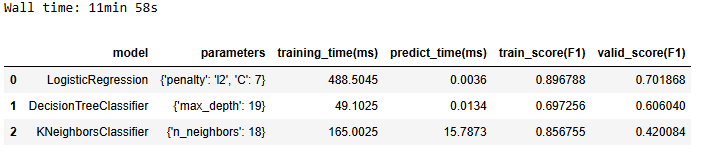

alpha = 1.5 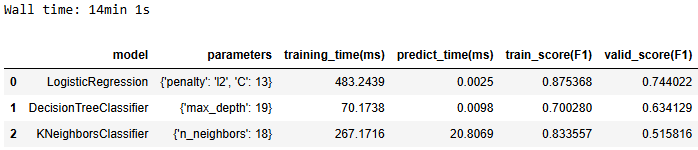

## Оценка качества и выбор лучшей модели

Теперь предскажем метки класса тестовой выборки, используя лучшую модель с оптимальными гиперпараметрами.

In [33]:
best_parm_logisticregression = models_df['parameters'][0]

In [34]:
model = LogisticRegression(penalty = best_parm_logisticregression['penalty'],
                           C=best_parm_logisticregression['C'],
                           random_state=RANDOM_STATE)

In [35]:
model.fit(tfidf_train, y_train_under)

LogisticRegression(C=13, random_state=42)

In [36]:
pred = model.predict(tfidf_test)
f1_score(y_test, pred)

0.7774921451013996

Пороговое значение метрики F1 достигнуто.

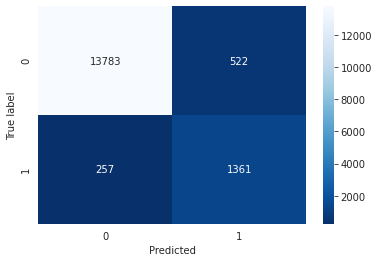

In [37]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

Судя по матрице ошибок, модель чаще допускает ошибку первого рода, то есть неверно предсказывает класс 1. Это может быть связано с тем, что модель обучалась на слегка сбалансированных данных, а предсказывала на несбалансированных. Возможно, если ещё увеличить параметр alpha, это улучшит качество предсказаний.

## Формулирование выводов

Цель проекта заключалась в разработке и обучении модели машинного обучения, способной классифицировать комментарии на позитивные и негативные (токсичные). Требовалось обеспечить хорошее качество классификации, достигая значения метрики F1 не менее 0.75. 

Для подготовки данных мы очистили тексты комментариев, оставив только буквы английского алфавита и приведя все символы к нижнему регистру. Далее мы разделили текст на токены, удалили стоп-слова и преобразовали оставшиеся слова в их начальную форму. Все эти операции выполнялись с помощью функции pre_processing(text).

Из-за дисбаланса классов модель могла плохо обучаться на минорном классе (1), поэтому была разработана функция undersampling(X_train, y_train, features, target, alpha=1), которая уменьшает размер мажорного класса для достижения баланса. Параметр alpha регулировал разницу между мажорным и минорным классом, и его можно было увеличивать для улучшения качества модели.

TF-IDF обучался только на необрезанных тренировочных данных для максимального увеличения словаря, после чего мы трансформировали сокращённую тренировочную, валидационную и тестовую выборки.

Модель LogisticRegression с регуляризатором L2 и коэффициентом регуляризации 10 показала положительный результат по метрике F1 на валидационной выборке. Параметр alpha был равен 2, что означало, что отношение количества элементов класса 0 к классу 1 составляло 2 к 1. Мы успешно достигли порогового значения метрики F1 в 0.774, что соответствует нашим требованиям.

Для улучшения метрики F1 можно попробовать другие технологии векторизации текста, а также экспериментировать с различными значениями параметра alpha. Можно рассмотреть обучение ансамблевых алгоритмов или нейронных сетей. Кроме того, стоит рассмотреть возможность подбора большего количества гиперпараметров для моделей, используемых в данном проекте.